# Continuous Control
--- 

### One Agent Reacher Solution

In [1]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment

env = UnityEnvironment(file_name='.\Reacher1\Reacher.exe', no_graphics=False)

# select this option to load version 2 (with 20 agents) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Define environment **_brains_** which are responsible for deciding the actions of their associated agents. Below checks for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### Examine the State and Action Spaces:

cells below print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
scores = np.zeros(num_agents)
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### Create Checkpoint to Save Agent Parameters

In [4]:
from agent import Agent
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
import time
%matplotlib inline


def save_checkpoint(model, optimizer, save_path, episode_num, 
                    min_scores,mean_scores, max_scores, moving_avgs, 
                    scores_window, best_score, duration):
        
    checkpointRes = {'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'episode_num': episode_num,
        'mean_scores': mean_scores,
        'min_scores': min_scores,
        'max_scores': max_scores,
        'moving_avgs': moving_avgs,
        'scores_window': scores_window,
        'best_score': best_score,
        'duration': duration}
    
    torch.save(checkpointRes, save_path)

### Define Training Routine

In [22]:
def ddpg(n_episodes=600, max_t=1000, train=True, num_agents=num_agents, print_every=2, train_mode=True, 
         load=False, actor_loadFile=None, critic_loadFile=None):
    
        
    #--------------------------------------------------------------------------------------------------#
    solved = False
    counter = 0
    if load==True and counter==0:
        
        actor_load = torch.load(actor_loadFile)
        critic_load = torch.load(critic_loadFile)
        stats = torch.load(critic_loadFile)
        
        mean_scores = stats['mean_scores']
        min_scores = stats['min_scores']
        max_scores = stats['max_scores']
        best_score = stats['best_score']
        moving_avgs = stats['moving_avgs']
        duration = stats['duration']
        episode_start = stats['episode_num']
        scores_window = stats['scores_window']
        
        agent.actor_local.load_state_dict(actor_load['model_state_dict'])
        agent.actor_optimizer.load_state_dict(actor_load['optimizer_state_dict'])
        
        agent.critic_local.load_state_dict(critic_load['model_state_dict'])
        agent.critic_optimizer.load_state_dict(critic_load['optimizer_state_dict'])
  
    elif load==False and counter==0:
        
        mean_scores = []
        min_scores = []
        max_scores = []
        best_score = -np.inf
        scores_window = deque(maxlen=100)
        moving_avgs = []
        duration = 0
        episode_start = 0
        episode_num = 0
        best_score = -np.inf
        
    #-----------------------------------------------------------------------------------------------------#
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        agent.reset()
        start_time = time.time()
        counter += 1
        episode_num = episode_start + counter

        for t in range(max_t): 
            actions = agent.act(states, add_noise=True)
            env_info = env.step(actions)[brain_name]     # send the action to the environment
            next_states = env_info.vector_observations   # get the next state
            rewards = env_info.rewards                   # get the reward
            dones = env_info.local_done                  # see if episode has finished
        
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, rewards, next_state, done, t, episode_num)
                
            states = next_states
            scores += rewards
            if np.any(dones):
                break

        duration += time.time() - start_time
        min_scores.append(np.min(scores))
        max_scores.append(np.max(scores))
        mean_scores.append(np.mean(scores))
        scores_window.append(mean_scores[-1])
        moving_avgs.append(np.mean(scores_window))
        best_score = max(best_score, np.max(scores))
                
        if episode_num % print_every == 0:
            print('\rEpisode {}, Mean last 100: {:.2f}, Mean current: {:.2f}, Max: {:.2f}, Min: {:.2f}, Best_Score {:.2f}, Time: {:.2f}'\
                .format(episode_num, moving_avgs[-1], mean_scores[-1], 
                        max_scores[-1], min_scores[-1], best_score, 
                        round(duration/60,2), end="\n"))
            
            
            save_checkpoint(agent.actor_local, agent.actor_optimizer, 'checkpoint_actor.pth', 
                            episode_num=episode_num, min_scores=min_scores,
                            mean_scores=mean_scores, max_scores=max_scores, 
                            moving_avgs=moving_avgs, scores_window=scores_window, 
                            best_score=best_score, duration=duration)
            
            save_checkpoint(agent.critic_local, agent.critic_optimizer, 'checkpoint_critic.pth', 
                            episode_num=episode_num, min_scores=min_scores,
                            mean_scores=mean_scores, max_scores=max_scores, 
                            moving_avgs=moving_avgs, scores_window=scores_window, 
                            best_score=best_score, duration=duration)
            
        if moving_avgs[-1]>=30.0 and solved==False:
            solved = True
            print('\n')
            print('\nEnvironment solved in {:d} episodes with an 100 turn Moving Average Score of {:.2f} over 100 turns'.format(episode_num, moving_avgs[-1]))
            print('\n')
    
            save_checkpoint(agent.actor_local, agent.actor_optimizer, 'checkpoint_actor_best.pth', 
                            episode_num=episode_num, min_scores=min_scores,
                            mean_scores=mean_scores, max_scores=max_scores, 
                            moving_avgs=moving_avgs, scores_window=scores_window, 
                            best_score=best_score, duration=duration)
            
            save_checkpoint(agent.critic_local, agent.critic_optimizer, 'checkpoint_critic_best.pth', 
                            episode_num=episode_num, min_scores=min_scores,
                            mean_scores=mean_scores, max_scores=max_scores, 
                            moving_avgs=moving_avgs, scores_window=scores_window, 
                            best_score=best_score, duration=duration)
    
    return mean_scores, moving_avgs, max_scores, min_scores

In [21]:
actor_loadFile = 'checkpoint_actor_150_solved.pth'
critic_loadFile = 'checkpoint_critic_150_solved.pth'

agent = Agent(state_size=state_size, action_size=action_size, random_seed=44)
mean_scores, moving_avgs, max_scores, min_scores = ddpg(load=True, actor_loadFile=actor_loadFile, critic_loadFile=critic_loadFile )




Environment solved in 151 episodes with an Average Score of 30.02




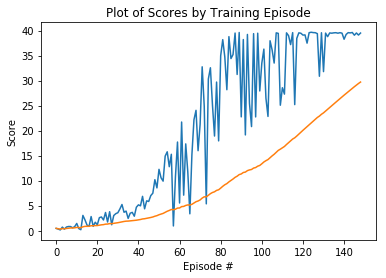

In [34]:
plt.title("Plot of Scores by Training Episode")
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.plot(mean_scores[:-2])
plt.plot(moving_avgs[:-2])
